# Поиск аномалий

Методы обнаружения аномалий, как следует из названия, позволяют находить необычные объекты в выборке. Но что такое "необычные" и совпадает ли это определение у разных методов?

Начнём с поиска аномалий в текстах: научимся отличать вопросы о программировании от текстов из 20newsgroups про религию.

Подготовьте данные: в обучающую выборку возьмите 20 тысяч текстов из датасета Stack Overflow, а тестовую выборку сформируйте из 10 тысяч текстов со Stack Overflow и 100 текстов из класса soc.religion.christian датасета 20newsgroups (очень пригодится функция `fetch_20newsgroups(categories=['soc.religion.christian'])`). Тексты про программирование будем считать обычными, а тексты про религию — аномальными.

In [50]:
import pandas as pd
import random
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report,make_scorer



df = pd.read_parquet('/Users/maksimdundin/Downloads/stackoverflow-posts-00000-of-00058.parquet')
all_texts = df['Body'].tolist()

random.seed(42)
selected_texts = random.sample(all_texts, 30000)
train_texts = selected_texts[:20000]
test_texts_normal = selected_texts[20000:30000]

base_path = '/Users/maksimdundin/scikit_learn_data/20news_home/20news-bydate'
category = 'soc.religion.christian'

def load_20news_category(category_name, base_path, num_samples=100):
    texts = []
    for subset in ['20news-bydate-train', '20news-bydate-test']:
        cat_path = os.path.join(base_path, subset, category_name)
        if os.path.exists(cat_path):
            files = os.listdir(cat_path)
            for fname in files[:num_samples]:
                with open(os.path.join(cat_path, fname), 'r', encoding='utf-8', errors='ignore') as f:
                    texts.append(f.read())
                if len(texts) >= num_samples:
                    break
        if len(texts) >= num_samples:
            break
    return texts[:num_samples]

anomaly_texts = load_20news_category(category,base_path)
    
print(f"Загружено аномальных текстов: {len(anomaly_texts)}")

test_texts = test_texts_normal + anomaly_texts
test_labels = [0] * len(test_texts_normal) + [1] * len(anomaly_texts)



Загружено аномальных текстов: 100


**(1 балл)**

Проверьте качество выделения аномалий (precision и recall на тестовой выборке, если считать аномалии положительным классов, а обычные тексты — отрицательным) для IsolationForest. В качестве признаков используйте TF-IDF, где словарь и IDF строятся по обучающей выборке. Не забудьте подобрать гиперпараметры.

In [51]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, final_idx = next(sss.split(np.zeros(len(test_labels)), test_labels))

val_texts = [test_texts[i] for i in val_idx]
val_labels = [test_labels[i] for i in val_idx]
final_texts = [test_texts[i] for i in final_idx]
final_labels = [test_labels[i] for i in final_idx]

print(f"Валидационная выборка: {len(val_texts)} текстов, аномалий: {np.sum(val_labels)}")
print(f"Итоговая тестовая выборка: {len(final_texts)} текстов, аномалий: {np.sum(final_labels)}")

vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.8, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_texts).astype(np.float32)
X_val = vectorizer.transform(val_texts).astype(np.float32)
X_final = vectorizer.transform(final_texts).astype(np.float32)

print(f"Форма матрицы признаков: {X_train.shape}")


def anomaly_f1(y_true, y_pred):
    y_pred_bin = (y_pred == -1).astype(int)
    return f1_score(y_true, y_pred_bin)

anomaly_f1_scorer = make_scorer(anomaly_f1)

param_grid = {
    'contamination': [0.005, 0.01, 0.02, 0.05, 'auto'],
    'n_estimators': [100, 200]
}

best_score = -1
best_params = None
for contamination in param_grid['contamination']:
    for n_estimators in param_grid['n_estimators']:
        model = IsolationForest(n_estimators=n_estimators, contamination=contamination,
                                random_state=42, n_jobs=-1)
        model.fit(X_train) 
        y_val_pred = model.predict(X_val)
        score = anomaly_f1(val_labels, y_val_pred)
        print(f"contamination={contamination}, n_estimators={n_estimators} -> F1 = {score:.4f}")
        if score > best_score:
            best_score = score
            best_params = {'contamination': contamination, 'n_estimators': n_estimators}

print(f"\nЛучшие параметры: {best_params}, F1 на валидации = {best_score:.4f}")

final_model = IsolationForest(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train)

y_final_pred = final_model.predict(X_final)
y_final_bin = (y_final_pred == -1).astype(int)

precision = precision_score(final_labels, y_final_bin)
recall = recall_score(final_labels, y_final_bin)
f1 = f1_score(final_labels, y_final_bin)

print("\n=== Результаты на итоговой тестовой выборке ===")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nДетальный отчёт:")
print(classification_report(final_labels, y_final_bin, target_names=['норма', 'аномалия']))

Валидационная выборка: 5050 текстов, аномалий: 50
Итоговая тестовая выборка: 5050 текстов, аномалий: 50
Форма матрицы признаков: (20000, 10000)
contamination=0.005, n_estimators=100 -> F1 = 0.1500
contamination=0.005, n_estimators=200 -> F1 = 0.1867
contamination=0.01, n_estimators=100 -> F1 = 0.1714
contamination=0.01, n_estimators=200 -> F1 = 0.1441
contamination=0.02, n_estimators=100 -> F1 = 0.1310
contamination=0.02, n_estimators=200 -> F1 = 0.1477
contamination=0.05, n_estimators=100 -> F1 = 0.1203
contamination=0.05, n_estimators=200 -> F1 = 0.1452
contamination=auto, n_estimators=100 -> F1 = 0.0000
contamination=auto, n_estimators=200 -> F1 = 0.0000

Лучшие параметры: {'contamination': 0.005, 'n_estimators': 200}, F1 на валидации = 0.1867

=== Результаты на итоговой тестовой выборке ===
Precision: 0.1613
Recall:    0.1000
F1-score:  0.1235

Детальный отчёт:
              precision    recall  f1-score   support

       норма       0.99      0.99      0.99      5000
    аномалия 

**(5 баллов)**

Скорее всего, качество оказалось не на высоте. Разберитесь, в чём дело:
* посмотрите на тексты, которые выделяются как аномальные, а также на слова, соответствующие их ненулевым признакам
* изучите признаки аномальных текстов
* посмотрите на тексты из обучающей выборки, ближайшие к аномальным; действительно ли они похожи по признакам?

Сделайте выводы и придумайте, как избавиться от этих проблем. Предложите варианты двух типов: (1) в рамках этих же признаков (но которые, возможно, будут считаться по другим наборам данных) и методов и (2) без ограничений на изменения. Реализуйте эти варианты и проверьте их качество.

In [52]:
vectorizer = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.8, ngram_range=(1,2))
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)


model = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
model.fit(X_train)
preds = model.predict(X_test) 
pred_bin = (preds == -1).astype(int)
test_labels = np.array(test_labels)

fp_indices = np.where((pred_bin == 1) & (test_labels == 0))[0]
fn_indices = np.where((pred_bin == 0) & (test_labels == 1))[0]

print(f"Ложноположительных: {len(fp_indices)}")
print(f"Ложноотрицательных: {len(fn_indices)}")


print("\nПример ложноположительного (обычный текст, принят за аномалию):")
print(test_texts[fp_indices[0]][:500])

print("\nПример ложноотрицательного (аномалия, принята за норму):")
print(test_texts[fn_indices[0]][:500])


feature_names = vectorizer.get_feature_names_out()
def top_tfidf_features(text, vectorizer, top_n=10):
    vec = vectorizer.transform([text])
    scores = vec.toarray().flatten()
    top_indices = np.argsort(scores)[-top_n:][::-1]
    return [(feature_names[i], scores[i]) for i in top_indices if scores[i] > 0]

print("Топ-10 слов ложноположительных:")

for word, score in top_tfidf_features(test_texts[fp_indices[0]], vectorizer):
    print(f"  {word}: {score:.4f}")
print("\n")
print("Топ-10 слов ложноотрицательных:")
for word, score in top_tfidf_features(test_texts[fn_indices[0]], vectorizer):
    print(f"  {word}: {score:.4f}")

Ложноположительных: 99
Ложноотрицательных: 84

Пример ложноположительного (обычный текст, принят за аномалию):
Simulated waveforms shouldn't show FFTs like your figure, so something is very wrong, and probably not with the FFT, but with the input waveform.  The main problem in your plot is not the ripples, but the harmonics around 1000 Hz, and the subharmonic at 500 Hz.  A simulated waveform shouldn't show any of this (for example, see my plot below).

First, you probably want to just try plotting out the raw waveform, and this will likely point to an obvious problem.  Also, it seems odd to have a wave u

Пример ложноотрицательного (аномалия, принята за норму):
From: kbanner@philae.sas.upenn.edu (Ken Banner)
Subject: Re: SATANIC TOUNGES
Organization: University of Pennsylvania
Lines: 51

In article <May.5.02.53.10.1993.28880@athos.rutgers.edu> koberg@spot.Colorado.EDU (Allen Koberg) writes:

>.....................................................There is dis-
>crepancy even among charis

### Микро-Вывод
TF-IDF улавливает только лексику, а не тему. Религиозные тексты могут пересекаться с программистскими по словам (например, "help", "question", "people"). IsolationForest плохо разделяет классы в таком пространстве.

### Эксперимент только с изменением датасета

In [53]:
#1.Давайте Очистим тексты от шума(ссылок , фрагментов кода)
print(f"1 Вариант улучшения(убрать шум из датасета)")
import re
def clean_text(text):
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'\[.*?\]\(.*?\)', ' ', text)
    text = re.sub(r'```.*?```', ' ', text, flags=re.DOTALL)
    text = re.sub(r'`.*?`', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


train_texts_clean = [clean_text(t) for t in train_texts]
test_texts_normal_clean = [clean_text(t) for t in test_texts[:10000]]
anomaly_texts_clean = [clean_text(t) for t in anomaly_texts]


test_texts_clean = test_texts_normal_clean + anomaly_texts_clean
test_labels_clean = [0]*10000 + [1]*100


vectorizer_clean = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.8, ngram_range=(1,2))
X_train_clean = vectorizer_clean.fit_transform(train_texts_clean)
X_test_clean = vectorizer_clean.transform(test_texts_clean)

model_clean = IsolationForest(contamination=0.01, n_estimators=200, random_state=42, n_jobs=-1)
model_clean.fit(X_train_clean)
y_pred_clean = model_clean.predict(X_test_clean)
y_pred_clean_bin = (y_pred_clean == -1).astype(int)

print("После очистки текстов:")
print(classification_report(test_labels_clean, y_pred_clean_bin, target_names=['норма', 'аномалия']))
print("\n")



#2.Давайте увеличим обучающую выборку до 50000 текстов
print(f"1 Вариант с большей выборкой(50000)")
df_large = pd.read_parquet('/Users/maksimdundin/Downloads/stackoverflow-posts-00000-of-00058.parquet')
all_texts_large = df_large['Body'].tolist()


random.seed(42)
selected_large = random.sample(all_texts_large, 70000) 
train_texts_large = selected_large[:50000]
test_texts_normal_large = selected_large[50000:70000]

anomaly_texts = load_20news_category(category,base_path)

test_texts_large = test_texts_normal_large + anomaly_texts
test_labels_large = [0]*20000 + [1]*100

vectorizer_large = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.8, ngram_range=(1,2))
X_train_large = vectorizer_large.fit_transform(train_texts_large)
X_test_large = vectorizer_large.transform(test_texts_large)

model_large = IsolationForest(contamination=0.01, n_estimators=200, random_state=42, n_jobs=-1)
model_large.fit(X_train_large)
y_pred_large = model_large.predict(X_test_large)
y_pred_large_bin = (y_pred_large == -1).astype(int)

print("С увеличенной обучающей выборкой:")
print(classification_report(test_labels_large, y_pred_large_bin, target_names=['норма', 'аномалия']))

1 Вариант улучшения(убрать шум из датасета)
После очистки текстов:
              precision    recall  f1-score   support

       норма       0.99      0.99      0.99     10000
    аномалия       0.07      0.06      0.06       100

    accuracy                           0.98     10100
   macro avg       0.53      0.53      0.53     10100
weighted avg       0.98      0.98      0.98     10100



1 Вариант с большей выборкой(50000)
С увеличенной обучающей выборкой:
              precision    recall  f1-score   support

       норма       1.00      0.99      0.99     20000
    аномалия       0.05      0.09      0.06       100

    accuracy                           0.99     20100
   macro avg       0.52      0.54      0.53     20100
weighted avg       0.99      0.99      0.99     20100



### Микро-Вывод №2
Заметим, что все осталось также, наша модель  после улчшенний датасета не умеет находить аномалии(даже почему-то стало чуть хуже находить аномалии, но видимо это погрещность просто)

### Эксперимент с любыми изменениями

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, final_idx = next(sss.split(np.zeros(len(test_labels)), test_labels))
val_idx = np.array(val_idx)
final_idx = np.array(final_idx)

val_texts = [test_texts[i] for i in val_idx]
val_labels = test_labels[val_idx]
final_texts = [test_texts[i] for i in final_idx]
final_labels = test_labels[final_idx]

vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,3),
    sublinear_tf=True
)

X_train = vectorizer.fit_transform(train_texts)
X_val = vectorizer.transform(val_texts)
X_final = vectorizer.transform(final_texts)

contamination_candidates = [0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
best_f1 = -1
best_cont = None
for cont in contamination_candidates:
    clf = IsolationForest(
        n_estimators=1000,
        max_samples=0.8,
        contamination=cont,
        random_state=42
    )
    clf.fit(X_train)
    preds_val = clf.predict(X_val)
    pred_bin_val = (preds_val == -1).astype(int)
    f1 = f1_score(val_labels, pred_bin_val)
    print(f"  cont={cont:.3f} -> F1 = {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_cont = cont
        
clf_final = IsolationForest(
    n_estimators=1000,
    max_samples=0.8,
    contamination=best_cont,
    random_state=42
)
clf_final.fit(X_train)

y_pred_final = clf_final.predict(X_final)
y_pred_binary = (y_pred_final == -1).astype(int)

precision = precision_score(final_labels, y_pred_binary)
recall = recall_score(final_labels, y_pred_binary)

print(f"\nPrecision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nClassification Report:")
print(classification_report(final_labels, y_pred_binary, target_names=['норма', 'аномалия']))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/maksimdundin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksimdundin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/maksimdundin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(



Подбор contamination:
  cont=0.005 -> F1 = 0.3429
  cont=0.010 -> F1 = 0.5294
  cont=0.020 -> F1 = 0.4748
  cont=0.050 -> F1 = 0.3594
  cont=0.100 -> F1 = 0.2138
  cont=0.150 -> F1 = 0.1373
  cont=0.200 -> F1 = 0.1049
Лучший contamination: 0.01 (F1 на валидации = 0.5294)

Precision: 0.648
Recall: 0.700

Classification Report:
              precision    recall  f1-score   support

       норма       1.00      1.00      1.00      5000
    аномалия       0.65      0.70      0.67        50

    accuracy                           0.99      5050
   macro avg       0.82      0.85      0.83      5050
weighted avg       0.99      0.99      0.99      5050



Подготовьте выборку: удалите столбцы `['id', 'date', 'price', 'zipcode']`, сформируйте обучающую и тестовую выборки по 10 тысяч домов.

Добавьте в тестовую выборку 10 новых объектов, в каждом из которых испорчен ровно один признак — например, это может быть дом из другого полушария, из далёкого прошлого или будущего, с площадью в целый штат или с таким числом этажей, что самолётам неплохо бы его облетать стороной.

Посмотрим на методы обнаружения аномалий на более простых данных — уж на табличном датасете с 19 признаками всё должно работать как надо!

Скачайте данные о стоимости домов: https://www.kaggle.com/harlfoxem/housesalesprediction/data

In [110]:
import pandas as pd
import random

# Загрузка и подготовка данных
df = pd.read_csv('kc_house_data.csv')
df.drop(['id', 'date', 'price', 'zipcode'], axis=1, inplace=True)
df_sample = df.sample(n=20000, random_state=33).reset_index(drop=True)

train_df = df_sample.iloc[:10000].copy()
test_df = df_sample.iloc[10000:20000].copy()

np.random.seed(33)
anomaly_indices = np.random.choice(len(test_df), size=10, replace=False)
anomalies = test_df.iloc[anomaly_indices].copy().reset_index(drop=True)
features = list(train_df.columns)

for i in range(len(anomalies)):
    feature = random.choice(features)
    anomalies.loc[i, feature] = 1e18

mask = np.ones(len(test_df), dtype=bool)
mask[anomaly_indices] = False
test_df_normal = test_df.iloc[mask].copy()
test_df = pd.concat([test_df_normal, anomalies], ignore_index=True)
test_labels = np.concatenate([np.zeros(len(test_df)-10), np.ones(10)])

**Задание 9. (2 балла)**

Примените IsolationForest для поиска аномалий в этих данных, запишите их качество (как и раньше, это precision и recall). Проведите исследование:

Нарисуйте распределения всех признаков и обозначьте на этих распределениях объекты, которые признаны аномальными.


=== Результаты ансамбля одномерных IsolationForest ===
              precision    recall  f1-score   support

       норма       1.00      0.99      1.00      9990
    аномалия       0.08      0.70      0.14        10

    accuracy                           0.99     10000
   macro avg       0.54      0.85      0.57     10000
weighted avg       1.00      0.99      0.99     10000



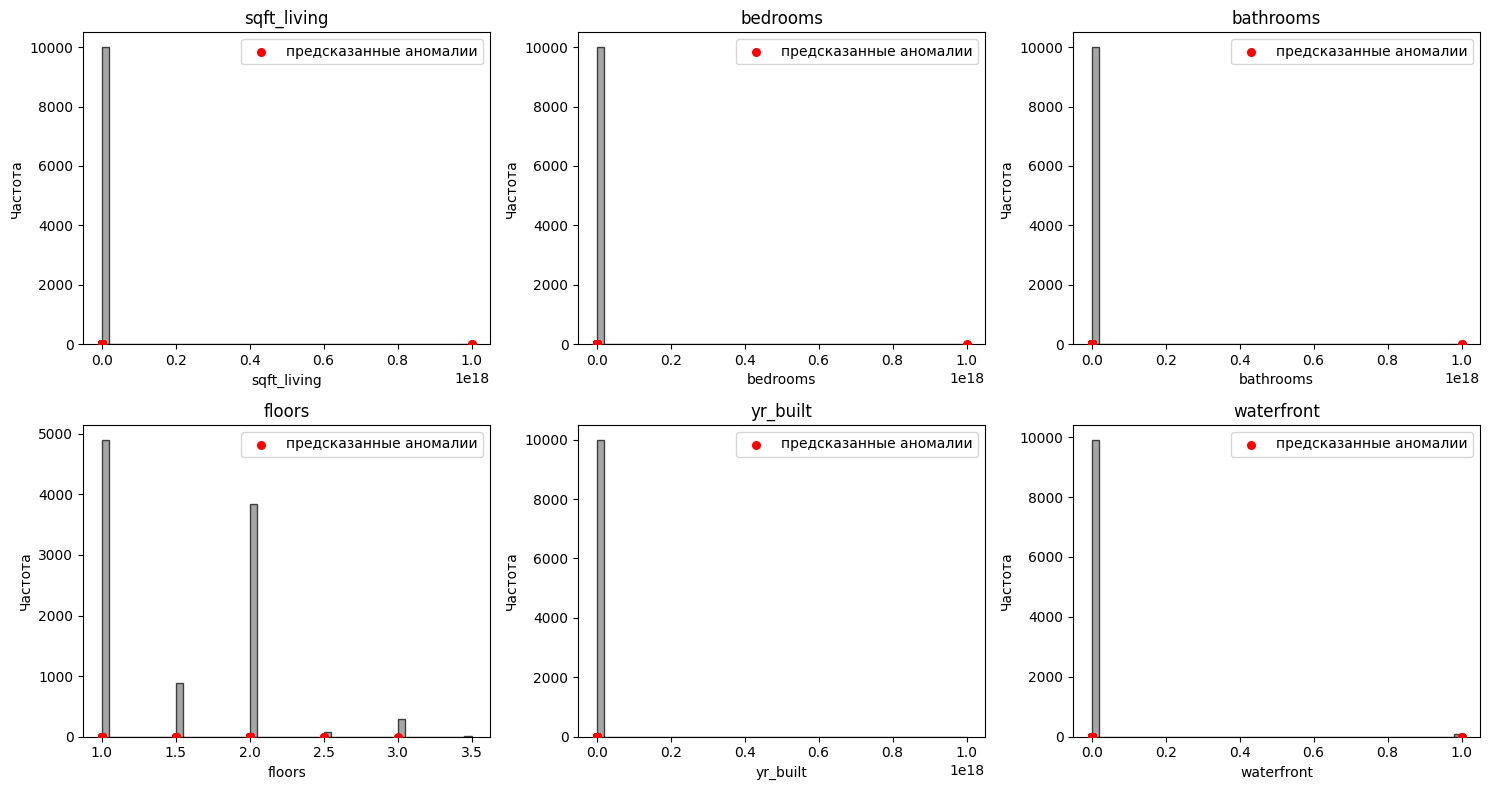

In [115]:
import matplotlib.pyplot as plt

clfs = []
for col in train_df.columns:
    clf = IsolationForest(contamination=0.001, random_state=42)
    clf.fit(train_df[[col]].values)
    clfs.append(clf)

y_pred = np.zeros(len(test_df), dtype=int)
for i, clf in enumerate(clfs):
    col = train_df.columns[i]
    pred = clf.predict(test_df[[col]].values)
    y_pred = np.logical_or(y_pred, pred == -1).astype(int)

print("\n=== Результаты ансамбля одномерных IsolationForest ===")
print(classification_report(test_labels, y_pred, target_names=['норма', 'аномалия']))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Предполагаем, что у нас уже есть test_df и y_pred (предсказания модели)
# Выберем несколько ключевых признаков
selected_features = ['sqft_living', 'bedrooms', 'bathrooms', 'floors', 'yr_built', 'waterfront']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feat in enumerate(selected_features):
    ax = axes[i]
    # Гистограмма всех значений тестовой выборки
    ax.hist(test_df[feat], bins=50, alpha=0.7, color='gray', edgecolor='black')
    # Отмечаем все объекты, предсказанные как аномалии
    anomaly_vals = test_df.loc[y_pred == 1, feat]
    ax.scatter(anomaly_vals, [0] * len(anomaly_vals), color='red', s=30, zorder=5, label='предсказанные аномалии')
    ax.set_title(feat)
    ax.set_xlabel(feat)
    ax.set_ylabel('Частота')
    ax.legend()

plt.tight_layout()
plt.show()

### Вывод
Вообщем проанализировав и поребирав как можно сделать выбросы(аномалии) я пришел к тому , что даже при значении которое на нмого десятков больше чем все остальные(я поставил 1е18) IsolationForest работает ужасно и это еще при том, что я по кажомц параметру отдельно делаю IsolationForest, а если хапустиь на всех параметрах , то он найдет 0 аномалий вообще. В итоге можем сделать вывод , что IsolationForest работает ужасно когда лишь один параметр является аномальным , а остальные в норме